In [417]:
%load_ext autoreload
%autoreload 2
import sys, os

sys.path.append('../utils/') 

from config import *
import dataset_utils as utils
import nlp_utils as nlp
import encoding_utils as encoding

import glob
import json
import argparse
import numpy as np
import pandas as pd 
import nibabel as nib
from nilearn.input_data import NiftiMasker
import librosa

import torch
import himalaya

from surfplot import Plot
from plotting_utils import vol_to_surf, make_layers_dict, plot_surf_data, combine_images

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /dartfs-hpc/rc/home/w/f003rjw/.cache/huggingface/token
Login successful
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
DATASET = 'huth-moth'
TASK = 'wheretheressmoke'

gentle_dir = os.path.join(DATASETS_DIR, DATASET, 'stimuli', 'gentle', TASK)
transcript_fn = os.path.join(gentle_dir, 'align.json')

df_transcript = encoding.load_gentle_transcript(
    transcript_fn=transcript_fn, 
    start_offset=None #stim_times[0] if stim_times else None
)

## MAKE ADJUSTMENTS TO MODEL FEATURES FROM BEHAVIOR ########
behavior_results_fn = os.path.join(BASE_DIR, f'derivatives/results/behavioral/task-{TASK}_compiled-behavior.csv')
behavior_results = pd.read_csv(behavior_results_fn)

crit_idxs = np.unique(behavior_results['word_index'])

In [7]:
masks_dir = os.path.join(DATASETS_DIR, DATASET, 'derivatives/masks/group/')

## some specific things for the dataset
mask_fn = os.path.join(masks_dir, 'group-MNI152NLin6Asym_res-all_desc-brain_gm-mask-intersection.nii.gz')
masker = NiftiMasker(mask_fn).fit()

## Analysis 01 -- Runwise prediction differences

In [ ]:
os.listdir(os.path.join(results_dir, sub_list[0]))

In [ ]:
sub_runs = sorted(glob.glob(os.path.join(results_dir, sub_list[0], '*wheretheressmoke*prediction*')))

In [ ]:
dss_sub = []

for run_fn in sub_runs:
    ds_sub = np.load(run_fn)
    dss_sub.append(ds_sub)
#     ds_nii = masker.inverse_transform(ds_sub)

In [ ]:
dss_sub = np.vstack(dss_sub)

In [ ]:
abs(dss_sub)

In [ ]:
max_pred = np.argmax(dss_sub, axis=0).astype(float)
max_pred[np.any(abs(dss_sub) <= 0.02, axis=0)] = np.nan

In [ ]:
# plot the volume correlation
# max_val = np.nanmax(abs(ds_sub))

ds_nii = masker.inverse_transform(max_pred)
surfs, data = vol_to_surf(ds_nii, surf_type='fsaverage', map_type='inflated')
layer = make_layers_dict(data=data, cmap='rainbow', label=f'Best run', alpha=1, color_range=(0, 5))


In [ ]:
_ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
                   add_depth=ADD_DEPTH, out_fn=None, title=None, embed_nb=True)

## Analysis 02 -- Substitute word vectors

### Load all features for model

In [52]:
import joblib
import typing
from pathlib import Path
from himalaya.scoring import correlation_score

results_dir = os.path.join(BASE_DIR, 'derivatives/results', DATASET)
sub_list = sorted([d for d in os.listdir(results_dir) if 'sub' in d])

def get_sub_predictions(sub, model_name, features):
    
    sub_dir = os.path.join(results_dir, sub, model_name)
    model_fn = os.path.join(sub_dir, f'{sub}_encoding-model_iter-00001.pkl')
    
    with open(model_fn, 'rb') as f:
        encoding_pipeline = joblib.load(f)
        
    print (f'Model loaded')
    
    # get model predictions for each
    if isinstance(behav_features, typing.Iterable):
        Y_pred = [encoding_pipeline.predict(feature) for feature in features]
    else:
        Y_pred = encoding_pipeline.predict(features)
    
    print (f'Finished model prediction')
    
    # load the distribution of correlations
    dist_fn = glob.glob(os.path.join(sub_dir, f'*permutations*'))
    
    assert (len(dist_fn) == 1)
    dist = np.load(dist_fn[0])
    
    return Y_pred, dist

def load_features(feature_names):
    
    regressors_dir = os.path.join(BASE_DIR, 'derivatives/regressors/', DATASET, TASK)
    # load the model features
    all_feature_fns = []

    for feature in feature_names:
        feature_fns = sorted(glob.glob(os.path.join(regressors_dir, feature, '*.npy')))
        all_feature_fns.append(feature_fns)
    
    # expand the list of lists
    # get all filenames and the grab their feature names
    all_features_fns = sum(all_feature_fns, [])        
    features_names = ['_'.join(Path(fn).stem.split('_')[1:]) for fn in all_features_fns]

    # load the features
    banded_info = encoding.load_banded_features(all_features_fns, features_names)
    return banded_info
    
def load_behavioral_features(model_name, behavior_features, base_features=['spectral', 'phoneme', 'word2vec']):

    regressors_dir = os.path.join(BASE_DIR, 'derivatives/regressors/', DATASET, TASK)
    # load the model features
    all_feature_fns = []

    for feature in base_features:
        feature_fns = sorted(glob.glob(os.path.join(regressors_dir, feature, '*.npy')))
        all_feature_fns.append(feature_fns)
    
    # now load behavioral features
    all_behav_info = []
    
    for feature in behavior_features:
        feature_fns = sorted(glob.glob(os.path.join(regressors_dir,  f'behavioral/{model_name}/*{feature}*.npy')))
        
        # expand the list of lists
        # get all filenames and the grab their feature names
        behav_feature_fns = sum([*all_feature_fns, feature_fns], [])        
        behav_feature_names = ['_'.join(Path(fn).stem.split('_')[1:]) for fn in behav_feature_fns]
        
        # load the features
        behav_features, behav_feature_names = encoding.load_banded_features(behav_feature_fns, behav_feature_names)
        print (f'Loaded features for {model_name} {feature}')
        print (f'{behav_feature_names}\n\n')
        
        all_behav_info.append((f'{model_name}_{feature}', behav_features))
    
    return all_behav_info

def calculate_accuracy_error(sub, task, preds, crit_trs):
    
    data_dir = os.path.join(DATASETS_DIR, DATASET, 'derivatives/dark-matter-preproc-smooth/', sub)
    sub_data_fns = sorted(glob.glob(os.path.join(data_dir, f'*{task}*hyperaligned.npy')))
    
    # load all files and append the mean of the files
    Y_test = [np.load(fn) for fn in sub_data_fns]
    Y_test.append(np.mean(Y_test, axis=0))
    
    all_residuals = np.stack([abs(Y_test - pred) for pred in preds])[:, :, crit_trs, :]
    all_predictions = np.stack([correlation_score(Y_test[-1], pred) for pred in preds])
    print (f'Finished calculating accuracy/residuals')
    
    return all_predictions, all_residuals

def get_residuals_df(sub, residuals, feature_names, significant):
    
    all_contrasts = []
    
    runs = [f'run-{i+1}' for i in np.arange(5)]
    runs += ['run-avg']
    
    for i, name in enumerate(feature_names):
         # first average across time
            
        voxelwise_residuals = residuals[i].mean(1)
#         voxelwise_diff = (abs(residuals[comp_idxs[0]]) - abs(residuals[comp_idxs[1]])).mean(1)
        
        df_voxels = pd.DataFrame(voxelwise_residuals.T, columns=runs)
        
        df_voxels = df_voxels.reset_index().rename(columns={'index': 'voxel'})
        df_voxels['sub'] = sub
        df_voxels['feature_name'] = name
        df_voxels['significant'] = significant
        df_voxels = pd.melt(df_voxels, id_vars=['voxel', 'sub', 'feature_name', 'significant'], var_name='run', value_name='resid')
        
        all_contrasts.append(df_voxels)
    
    return pd.concat(all_contrasts)

def get_parcel_difference(parcels, model_residuals, human_residuals):
    
    n_parcels = np.unique(parcels)[1:].astype(int)
    parcel_resid_diff = {}

    for parcel in n_parcels: 
        parcel_idxs = np.where(parcels == parcel)[0].squeeze()

        # significant parcel voxels --> then find percentage out of all
        model_parcel_resid = model_residuals[..., parcel_idxs]
        human_parcel_resid = human_residuals[..., parcel_idxs]
        
        # first average across time, then average across space (retaining runs)
        parcel_resid_diff[parcel] = (abs(model_parcel_resid) - abs(human_parcel_resid)).mean(1).mean(-1)
    return parcel_resid_diff
#     sys.exit(0)

In [452]:
all_features_names

['ground-truth', 'model-predicted', 'human-audio', 'human-text']

In [453]:
gt_features = zscore(all_features[0], axis=0)
model_features = zscore(all_features[1], axis=0)
audio_features = zscore(all_features[2], axis=0)

In [439]:
gt_features.shape

(300, 78867)

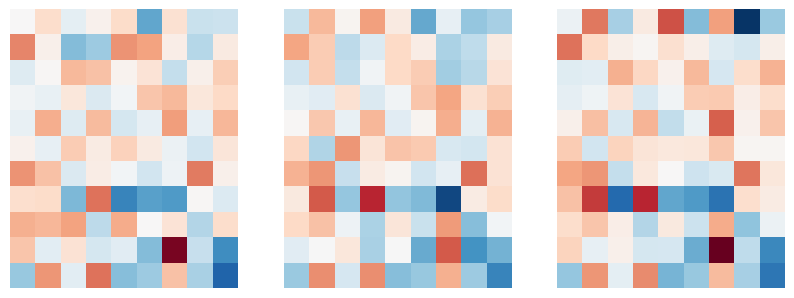

In [462]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharey=True)

axes[0].matshow(gt_features[50:61, 1000:1009], cmap='RdBu_r', vmin=-3, vmax=3)
axes[1].matshow(model_features[50:61, 1000:1009], cmap='RdBu_r', vmin=-3, vmax=3)
axes[2].matshow(audio_features[50:61, 1000:1009], cmap='RdBu_r', vmin=-3, vmax=3)

for ax in axes.ravel():
    ax.set_axis_off()
    
plt.savefig('example_matrices.pdf', bbox_inches='tight', dpi=300)

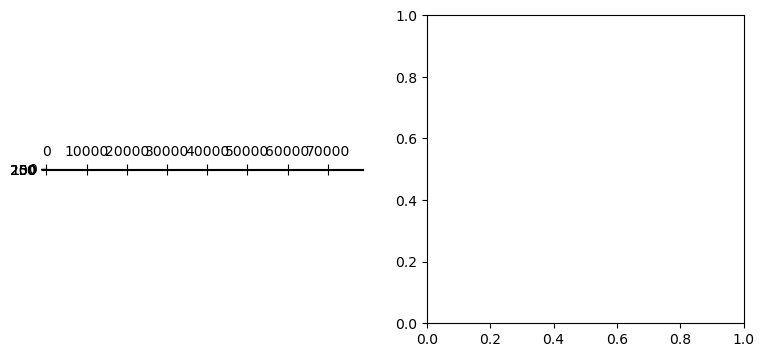

In [438]:
from scipy.stats import zscore

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].matshow(gt_features,
               cmap='binary_r', vmin=-3, vmax=3)

### Collect the data!

In [73]:
import statistics_utils as stats

MODEL_NAME = 'gpt2-xl'

# get critical word trs
critical_word_trs = df_transcript.loc[crit_idxs, ['start', 'end']] // 2
critical_word_trs = critical_word_trs['end'].astype(int).to_numpy()

# load features for each space
behav_features_names = ['model-predicted', 'human-audio', 'human-text']
behavioral_feature_info = load_behavioral_features(model_name=MODEL_NAME, behavior_features=behav_features_names)
_, behav_features = zip(*behavioral_feature_info)

# now load gt features
gt_features, gt_feature_names = load_features(feature_names=['spectral', 'phoneme', 'word2vec', MODEL_NAME])
all_features_names = ['ground-truth', *behav_features_names]
all_features = [gt_features, *behav_features]

# # set comparisons 
# comparisons = list(zip(
#     ['model-gt', 'model-audio', 'model-text', 'audio-gt', 'text-gt', 'audio-text'], 
#     [[1, 0], [1,2], [1,3], [2, 0], [3, 0], [2, 3]]
# ))

all_sub_residuals = []
all_sub_corrs_info = []

for sub in sorted(sub_list):
    
    print (f'Starting {sub}')
    # make predictions for each feature set
    Y_preds, dist = get_sub_predictions(sub=sub, model_name=MODEL_NAME, features=all_features)

    # calculate residuals over predictions for each and all stories
    corrs, residuals = calculate_accuracy_error(sub=sub, task=TASK, preds=Y_preds, crit_trs=critical_word_trs)
    
    # compare ground truth to null distribution
    # then log together with the baseline correlation
    # results in corrs array, zvals, pvals for each subject
    zvals, pvals = stats.p_from_null(corrs[0][np.newaxis], dist, mult_comp_method='fdr_bh', axis=0)
    all_sub_corrs_info.append([corrs[0], zvals, pvals])
    
    # find significance to add to df
    thresholded = stats.pvalue_threshold(corrs[0], pvals)
    significant = ~np.isnan(thresholded)
    
    df_sub_residuals = get_residuals_df(sub=sub, residuals=residuals, feature_names=all_features_names, significant=significant)
    all_sub_residuals.append(df_sub_residuals)
    print (f'Finished {sub}')

Loaded features for gpt2-xl model-predicted
[('features-spectral', slice(0, 128, None)), ('features-phoneme', slice(128, 167, None)), ('features-word2vec', slice(167, 467, None)), ('model-gpt2-xl_layer-001_model-predicted', slice(467, 2067, None)), ('model-gpt2-xl_layer-002_model-predicted', slice(2067, 3667, None)), ('model-gpt2-xl_layer-003_model-predicted', slice(3667, 5267, None)), ('model-gpt2-xl_layer-004_model-predicted', slice(5267, 6867, None)), ('model-gpt2-xl_layer-005_model-predicted', slice(6867, 8467, None)), ('model-gpt2-xl_layer-006_model-predicted', slice(8467, 10067, None)), ('model-gpt2-xl_layer-007_model-predicted', slice(10067, 11667, None)), ('model-gpt2-xl_layer-008_model-predicted', slice(11667, 13267, None)), ('model-gpt2-xl_layer-009_model-predicted', slice(13267, 14867, None)), ('model-gpt2-xl_layer-010_model-predicted', slice(14867, 16467, None)), ('model-gpt2-xl_layer-011_model-predicted', slice(16467, 18067, None)), ('model-gpt2-xl_layer-012_model-predicte

Starting sub-UTS01
Model loaded
Finished model prediction
Finished calculating accuracy/residuals
Finished sub-UTS01
Starting sub-UTS02
Model loaded
Finished model prediction
Finished calculating accuracy/residuals
Finished sub-UTS02
Starting sub-UTS03
Model loaded
Finished model prediction
Finished calculating accuracy/residuals
Finished sub-UTS03
Starting sub-UTS04
Model loaded
Finished model prediction
Finished calculating accuracy/residuals
Finished sub-UTS04
Starting sub-UTS05
Model loaded
Finished model prediction
Finished calculating accuracy/residuals
Finished sub-UTS05
Starting sub-UTS06
Model loaded
Finished model prediction
Finished calculating accuracy/residuals
Finished sub-UTS06
Starting sub-UTS07
Model loaded
Finished model prediction
Finished calculating accuracy/residuals
Finished sub-UTS07
Starting sub-UTS08
Model loaded
Finished model prediction
Finished calculating accuracy/residuals
Finished sub-UTS08


In [74]:
df_all_sub_residuals = pd.concat(all_sub_residuals)

In [45]:
df_all_sub_residuals.to_csv('all-sub-residuals.csv')

### Calculate difference of residuals

In [75]:
feature_contrasts = [
    ['model-predicted', 'human-audio'],
    ['model-predicted', 'human-text'],
    ['model-predicted', 'ground-truth'],
    ['human-audio', 'ground-truth'],
    ['human-text', 'ground-truth'],
    ['human-audio', 'human-text'] 
]

all_contrasts = []

for contrast in feature_contrasts:
    df_a, df_b = [df_all_sub_residuals[df_all_sub_residuals['feature_name'] == c] for c in contrast]
    
    # copy a dataframe and we'll insert to perform contrast
    df_contrast = df_a.copy()
    df_contrast['resid'] = df_a['resid'] - df_b['resid']
    df_contrast['feature_name'] = ' - '.join(contrast)
    
    all_contrasts.append(df_contrast)

df_contrast = pd.concat(all_contrasts)
df_contrast.rename(columns={'feature_name':'contrast'}, inplace=True)
# for i, df in df_all_sub_residuals.groupby('feature_name'):
#     print (i)

In [ ]:
df_contrast

### Assess prediction ability

In [346]:
def ztransform_mean(dss):
    return np.tanh(np.mean([np.arctanh(ds) for ds in dss], axis=0))

In [353]:
corrs, zvals, pvals = zip(*all_sub_corrs_info)
thresholded = stats.pvalue_threshold(np.stack(corrs), np.stack(pvals))



In [358]:
# now count number of participants 
significance_counts = np.sum(np.stack(pvals) < 0.05, axis=0).astype(float)
significance_counts[significance_counts < 1] = np.nan

significance_cmap = plt.cm.get_cmap('magma', len(sub_list))    # 11 discrete colorsp

out_fn = os.path.join(plots_dir, f'group_task-{TASK}_nsubs-significance.{EXT}')
title = ''#f'group - n_subs significance'

max_val = np.nanmax(significance_counts)
ds_signif = masker.inverse_transform(significance_counts)

surfs, data = vol_to_surf(ds_signif, surf_type='fsaverage', map_type='inflated', method='nearest')
layer = make_layers_dict(data=data, cmap=significance_cmap, label=f'N_Subjects Significant', alpha=1, color_range=(1, 8))

_ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=True, surf_type=SURF_TYPE, 
                   add_depth=ADD_DEPTH, out_fn=out_fn, title=title, embed_nb=False)
 
if PLOT_SEPARATE_VIEWS:
        for view in VIEWS:
            _ = plot_surf_data(surfs, [layer], views=[view], colorbar=COLORBAR, surf_type=SURF_TYPE, 
                add_depth=ADD_DEPTH, out_fn=out_fn.replace(f'.{EXT}', f'-{view}.{EXT}'),
                title=title)
else:
    _ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
        add_depth=ADD_DEPTH, out_fn=out_fn, title=title)

/scratch/ipykernel_25177/3929753252.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  significance_cmap = plt.cm.get_cmap('magma', len(sub_list))    # 11 discrete colorsp


Here
Here
Here


In [359]:
sub_avg = ztransform_mean(corrs)
sub_avg[np.isnan(significance_counts)] = np.nan

out_fn = os.path.join(plots_dir, f'group_task-{TASK}_run-avg-prediction.{EXT}')
title = '' #f'group - run-avg prediction'

max_val = np.nanmax(sub_avg)

ds_avg = masker.inverse_transform(sub_avg)

surfs, data = vol_to_surf(ds_avg, surf_type='fsaverage', map_type='inflated')
layer = make_layers_dict(data=data, cmap='RdBu_r', label=f'Prediction (r)', alpha=1, color_range=(-max_val, max_val))

_ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=True, surf_type=SURF_TYPE, 
                   add_depth=ADD_DEPTH, out_fn=out_fn, title=title, embed_nb=False)

if PLOT_SEPARATE_VIEWS:
    for view in VIEWS:
        _ = plot_surf_data(surfs, [layer], views=[view], colorbar=COLORBAR, surf_type=SURF_TYPE, 
            add_depth=ADD_DEPTH, out_fn=out_fn.replace(f'.{EXT}', f'-{view}.{EXT}'),
            title=title)
else:
    _ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
        add_depth=ADD_DEPTH, out_fn=out_fn, title=title)

Here
Here
Here


In [351]:
plots_dir = os.path.join(BASE_DIR, 'derivatives/plots/encoding_preds', DATASET, 'run-avg', MODEL_NAME)

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

max_val = np.nanmax([np.nanmax(abs(x)) for x in thresholded])

for sub, (corrs, zvals, pvals) in zip(sub_list, all_sub_corrs_info):
    
    out_fn = os.path.join(plots_dir, f'{sub}_task-{TASK}_run-avg-prediction.{EXT}')
    title = f'{sub} - run-avg prediction'
    
    # get thresholed data, inverse transform
    thresholded = stats.pvalue_threshold(corrs, pvals)
    ds_avg = masker.inverse_transform(thresholded)
    
    surfs, data = vol_to_surf(ds_avg, surf_type='fsaverage', map_type='inflated')
    layer = make_layers_dict(data=data, cmap='RdBu_r', label=f'Prediction (r)', alpha=1, color_range=(-max_val, max_val))

    if PLOT_SEPARATE_VIEWS:
            for view in VIEWS:
                _ = plot_surf_data(surfs, [layer], views=[view], colorbar=COLORBAR, surf_type=SURF_TYPE, 
                    add_depth=ADD_DEPTH, out_fn=os.path.join(plots_dir, plot_fn.replace(f'.{EXT}', f'-{view}.{EXT}')),
                    title=title)
        else:
            _ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
                add_depth=ADD_DEPTH, out_fn=os.path.join(plots_dir, plot_fn), title=title)


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 25)

### Run voxelwise analyses

In [122]:
df_run_avg = df_contrast[df_contrast['run'] == 'run-avg'].reset_index(drop=True)
df_run_avg = df_run_avg[df_run_avg['significant']]

df_run_avg

In [126]:
df_run_avg = df_run_avg[df_run_avg['contrast'].isin([
    'model-predicted - human-audio',
    'model-predicted - human-text',
    'human-audio - human-text'

])]

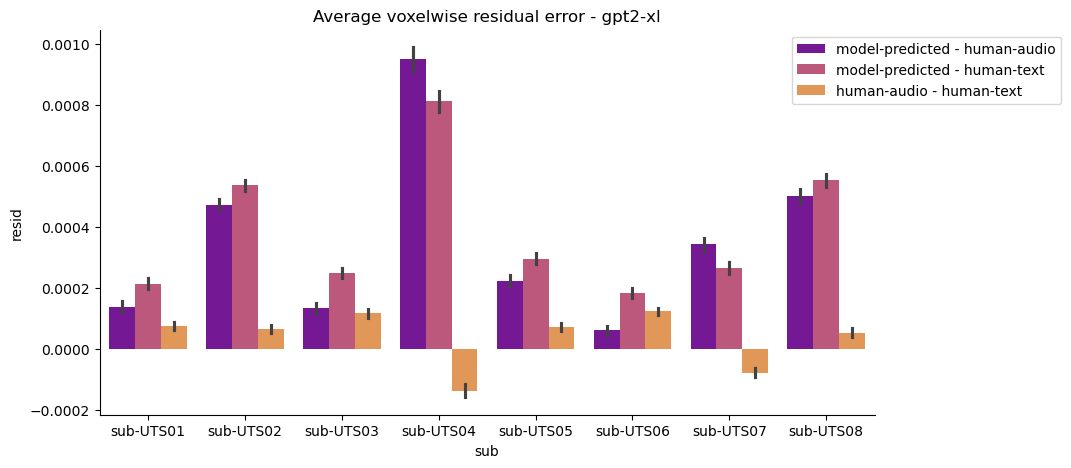

In [143]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(df_run_avg, x='sub', y='resid', hue='contrast', palette='plasma', ax=ax)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
# plt.ylim([-0.0003, 0.0008])

plt.title(f'Average voxelwise residual error - {MODEL_NAME}')
sns.despine()
# plt.yscale('log10')
# plt.tight_layout()
# plt.xscale('log')
# plt.ylabel('Negative log MSE Difference')
# plt

Plot average brain of residual error

In [309]:
df_run_avg = df_all_sub_residuals[df_all_sub_residuals['run'] == 'run-avg'].reset_index(drop=True)
df_run_avg = df_run_avg.groupby(['feature_name', 'voxel'], as_index=False)['resid'].mean()

In [310]:
all_residuals = [] 

for i, df in df_run_avg.groupby('feature_name'):
    
    all_residuals.append((i, df['resid'].to_numpy()))
    
feature_names, residuals = zip(*all_residuals)

In [311]:
feature_names

('ground-truth', 'human-audio', 'human-text', 'model-predicted')

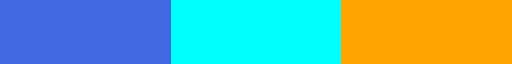

In [312]:
cmap

In [335]:
from matplotlib import colors

cmap = colors.ListedColormap(['royalblue', 'yellow', 'cyan', 'orange'])
color_range = (1, 4)

best_predictor = np.argmin(abs(np.stack(residuals)), axis=0).astype(float) + 1
best_predictor[np.isnan(significance_counts)] = np.nan

# now count number of participants 
out_fn = os.path.join(plots_dir, f'group-best-predictor_task-{TASK}_all-preds.{EXT}')
title = ''#f'group - n_subs significance'

ds_best_pred = masker.inverse_transform(best_predictor)

surfs, data = vol_to_surf(ds_best_pred, surf_type='fsaverage', map_type='inflated')
layer = make_layers_dict(data=data, cmap=cmap, label=f'Best predictor', alpha=1, color_range=color_range)

# if PLOT_SEPARATE_VIEWS:
#         for view in VIEWS:
#             _ = plot_surf_data(surfs, [layer], views=[view], colorbar=COLORBAR, surf_type=SURF_TYPE, 
#                 add_depth=ADD_DEPTH, out_fn=out_fn.replace(f'.{EXT}', f'-{view}.{EXT}'),
#                 title=title)
# else:
_ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
    add_depth=ADD_DEPTH, out_fn=out_fn.replace(f'.{EXT}', f'-{view}.{EXT}'), title=title)

Here


In [261]:
df_all_sub_residuals

,voxel,sub,feature_name,significant,run,resid
0,0,sub-UTS01,ground-truth,True,run-1,0.801334
1,1,sub-UTS01,ground-truth,True,run-1,0.813158
2,2,sub-UTS01,ground-truth,False,run-1,0.812402
3,3,sub-UTS01,ground-truth,True,run-1,0.756860
4,4,sub-UTS01,ground-truth,True,run-1,0.737781
...,...,...,...,...,...,...
341941,56986,sub-UTS08,human-text,False,run-avg,0.373334
341942,56987,sub-UTS08,human-text,True,run-avg,0.402660
341943,56988,sub-UTS08,human-text,True,run-avg,0.390217
341944,56989,sub-UTS08,human-text,False,run-avg,0.387767


In [419]:
df_run_avg = df_contrast[df_contrast['run'] == 'run-avg'].reset_index(drop=True)
df_run_avg = df_run_avg.groupby(['contrast', 'voxel'], as_index=False)['resid'].mean()

df_run_avg = df_run_avg[df_run_avg['contrast'].isin([
    'model-predicted - human-audio',
#     'model-predicted - human-text',
#     'model-predicted - ground-truth',
#     'human-audio - human-text'
#     'human-audio - ground-truth'

])]

# turn to log scale
# df_run_avg['resid'] = -1 * (np.sign(df_run_avg['resid']) * np.log10(abs(df_run_avg['resid'])))

max_val = abs(df_run_avg['resid']).max()

significance_counts = np.sum(np.stack(pvals) < 0.05, axis=0).astype(float)
significance_counts[significance_counts < 4] = np.nan

for i, df in df_run_avg.groupby('contrast'):
    
    contrast_name = i.replace(' - ', '_')
    
    avg_error = df['resid'].to_numpy()
    avg_error[np.isnan(significance_counts)] = np.nan
    
    out_fn = os.path.join(plots_dir, f'group_task-{TASK}_{contrast_name}-error.{EXT}')
    title = '' #f'group - {contrast_name} error'
    
    max_val = np.nanmax(abs(avg_error))
    ds_avg_error = masker.inverse_transform(avg_error)

    surfs, data = vol_to_surf(ds_avg_error, surf_type='fsaverage', map_type='inflated')
    layer = make_layers_dict(data=data, cmap='RdBu_r', label=f'MSE', alpha=1, color_range=(-max_val, max_val))
    
    _ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=True, surf_type=SURF_TYPE, 
                add_depth=ADD_DEPTH, out_fn=out_fn, title=title)
    
#     if PLOT_SEPARATE_VIEWS:
#         for view in VIEWS:
#             _ = plot_surf_data(surfs, [layer], views=[view], colorbar=COLORBAR, surf_type=SURF_TYPE, 
#                 add_depth=ADD_DEPTH, out_fn=out_fn.replace(f'.{EXT}', f'-{view}.{EXT}'),
#                 title=title)
#         else:
#             _ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
#                 add_depth=ADD_DEPTH, out_fn=out_fn, title=title)

Here


In [423]:
avg_error

array([-0.00058331,  0.00064262,  0.00106202, ...,  0.0008547 ,
        0.00021057,  0.00116216], dtype=float32)

In [425]:
tmp = np.empty(avg_error.shape)
tmp[:] = np.nan
tmp = masker.inverse_transform(tmp)

surfs, data = vol_to_surf(tmp, surf_type='fsaverage', map_type='inflated')
layer = make_layers_dict(data=data, cmap='RdBu_r', label=f'MSE', alpha=1, color_range=(-1, 1))

_ = plot_surf_data(surfs, [layer], views=['lateral'], colorbar=False, surf_type=SURF_TYPE, 
            add_depth=ADD_DEPTH, out_fn='blank_brain.png', title='')


Here


### Test contrast of contrasts

In [381]:
df_run_avg = df_contrast[df_contrast['run'] == 'run-avg'].reset_index(drop=True)
# df_run_avg = df_run_avg.groupby(['contrast', 'voxel'], as_index=False)['resid'].mean()

In [382]:
df_run_avg['contrast'].unique()

array(['model-predicted - human-audio', 'model-predicted - human-text',
       'model-predicted - ground-truth', 'human-audio - ground-truth',
       'human-text - ground-truth', 'human-audio - human-text'],
      dtype=object)

In [383]:
contrast_model = df_run_avg[df_run_avg['contrast'].isin(['model-predicted - ground-truth'])].reset_index(drop=True)
contrast_audio = df_run_avg[df_run_avg['contrast'].isin(['human-audio - ground-truth'])].reset_index(drop=True)

In [407]:
df_contrasts_of_contrasts = contrast_audio.copy()
df_contrasts_of_contrasts['resid'] = contrast_model['resid'] - contrast_audio['resid']
df_contrasts_of_contrasts = df_contrasts_of_contrasts.groupby(['voxel'], as_index=False)['resid'].mean()

In [408]:
avg_error = df_contrasts_of_contrasts['resid'].to_numpy()
avg_error[np.isnan(significance_counts)] = np.nan
# avg_error = -1 * (np.sign(avg_error) * np.log10(abs(avg_error)))

max_val = np.nanmax(abs(avg_error))

out_fn = os.path.join(plots_dir, f'group_task-{TASK}_contrasts-contrasts-error.jpg')
title = f'group - audio model diff error'

ds_avg_error = masker.inverse_transform(avg_error)

surfs, data = vol_to_surf(ds_avg_error, surf_type='fsaverage', map_type='inflated')
layer = make_layers_dict(data=data, cmap='RdBu_r', label=f'MSE', alpha=1, color_range=(-max_val, max_val))

_ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
                   add_depth=ADD_DEPTH, out_fn=out_fn, title=title, embed_nb=False)


Here


/scratch/ipykernel_25177/2915445507.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_run_avg, x='contrast', y='resid', palette='plasma', ax=ax)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Average voxelwise residual error - gpt2-xl')

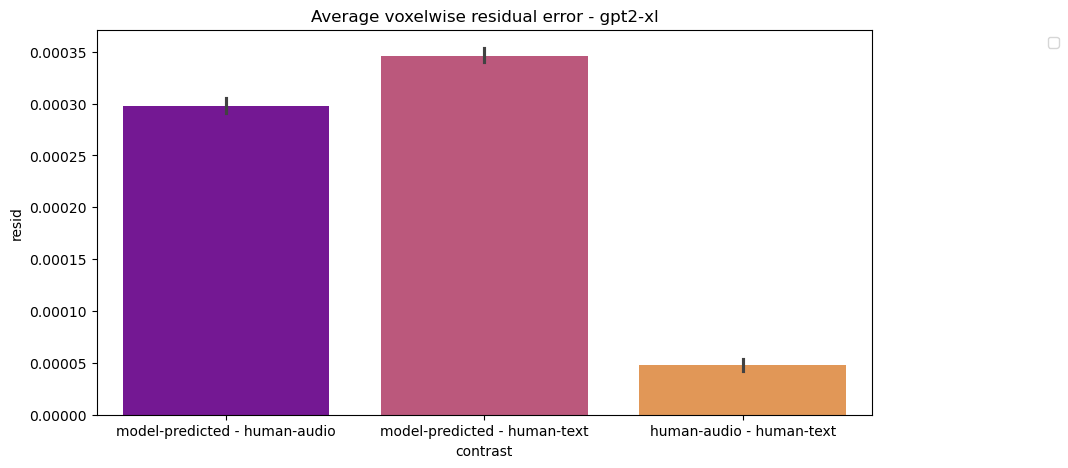

In [128]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(df_run_avg, x='contrast', y='resid', palette='plasma', ax=ax)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
# plt.ylim([-0.0003, 0.0008])

plt.title(f'Average voxelwise residual error - {MODEL_NAME}')

/scratch/ipykernel_25177/2915445507.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_run_avg, x='contrast', y='resid', palette='plasma', ax=ax)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Average voxelwise residual error - gpt2-xl')

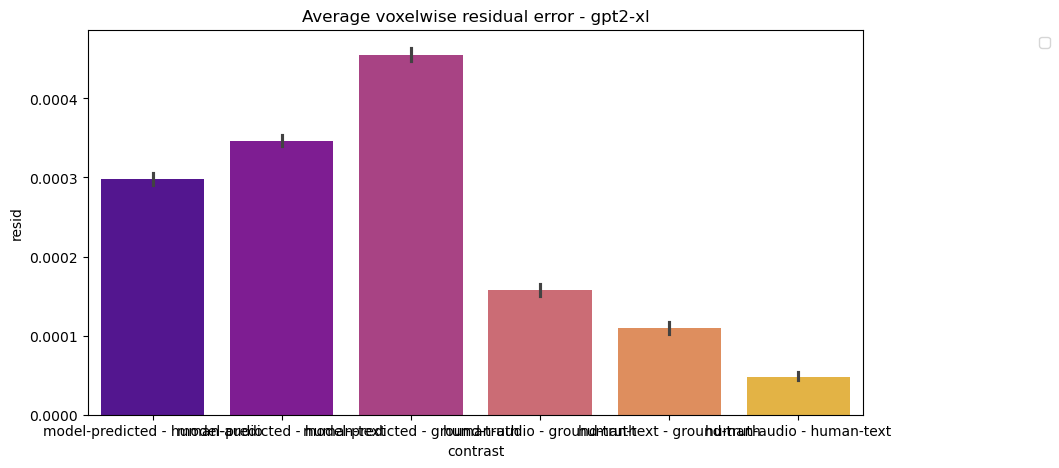

In [44]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(df_run_avg, x='contrast', y='resid', palette='plasma', ax=ax)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
# plt.ylim([-0.0003, 0.0008])

plt.title(f'Average voxelwise residual error - {MODEL_NAME}')

In [ ]:
# df_run_avg = df_all_sub_contrasts[df_all_sub_contrasts['run'] == 'run-avg']
df_avg_contrasts = df_run_avg.groupby(['voxel', 'contrast'], as_index=False)['resid'].mean()

df_sub_contrasts = df_run_avg[df_run_avg['sub'] == 'sub-UTS05'].reset_index(drop=True)
# df_avg_log_contrasts = convert_residuals_to_log(df_avg_contrasts)

In [ ]:
avg_vox_resid = df_sub_contrasts[df_sub_contrasts['contrast'] == 'model-audio']['resid'].to_numpy()

In [ ]:
# avg_vox_resid = df_voxel_diffs.groupby(['voxel']).mean()['resid'].to_numpy()
ds_avg = masker.inverse_transform(avg_vox_resid)
# max_val = abs(avg_vox_resid).max()
max_val = 0.01

surfs, data = vol_to_surf(ds_avg, surf_type='fsaverage', map_type='inflated')
layer = make_layers_dict(data=data, cmap='RdBu_r', label=f'MSE', alpha=1, color_range=(-max_val, max_val))

_ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
                   add_depth=ADD_DEPTH, out_fn=None, title='Average voxel-wise error across runs/subjects', embed_nb=True)


### Now load Glasser

In [ ]:
from nilearn.input_data import NiftiMasker
from nilearn.image import resample_to_img

# load the masker
parcels_fn = os.path.join(ATLAS_DIR, 'schaefer_2018', 'Schaefer2018_200Parcels_17Networks_order_FSLMNI152_2mm.nii.gz')
parcels_resampled = resample_to_img(parcels_fn, mask_fn, interpolation='nearest')

masker = NiftiMasker(mask_fn).fit()
parcels_masked = masker.transform(parcels_resampled).squeeze()

In [ ]:
all_parcel_diffs = []
all_voxel_diffs = []

runs = [f'run-{i+1}' for i in np.arange(5)]
runs = runs.extend('run-avg')
# runs = ['run-avg']

for sub in sorted(sub_list): 
    print (f'Starting {sub}')
    
    model_residuals, human_residuals = get_sub_residuals(sub, MODEL_NAME, model_all_features, human_all_features, crit_trs)
    voxelwise_resid_diff = (abs(model_residuals) - abs(human_residuals)).mean(1)
    parcel_resid_diff = get_parcel_difference(parcels_masked, model_residuals, human_residuals)
    
    # PARCELS --> turn dictionary into a dataframe
    # then rename the index to parcel and reset --> add in sub
    df_parcels = pd.DataFrame.from_dict(parcel_resid_diff, orient='index', columns=runs)
    df_parcels = df_parcels.reset_index().rename(columns={'index': 'parcel'})
    df_parcels['sub'] = sub
    df_parcels = pd.melt(df_parcels, id_vars=['parcel', 'sub'], var_name='run', value_name='resid')
    
    all_parcel_diffs.append(df_parcels)
    
    # VOXELS --> turn array into dataframe
    # then rename the index to parcel and reset --> add in sub
    
    df_voxels = pd.DataFrame(voxelwise_resid_diff.T, columns=runs)
    df_voxels = df_voxels.reset_index().rename(columns={'index': 'voxel'})
    df_voxels['sub'] = sub
    df_voxels = pd.melt(df_voxels, id_vars=['voxel', 'sub'], var_name='run', value_name='resid')

    all_voxel_diffs.append(df_voxels)

    print (f'Completed {sub}')
    
    

In [ ]:
df_parcel_diffs = pd.concat(all_parcel_diffs).reset_index(drop=True)
df_voxel_diffs = pd.concat(all_voxel_diffs).reset_index(drop=True)

In [ ]:
# avg_vox_resid = df_voxel_diffs.groupby(['voxel']).mean()['resid'].to_numpy()
ds_avg = masker.inverse_transform(avg_vox_resid)
max_val = abs(avg_vox_resid).max()

surfs, data = vol_to_surf(ds_avg, surf_type='fsaverage', map_type='inflated')
layer = make_layers_dict(data=data, cmap='RdBu_r', label=f'MSE', alpha=1, color_range=(-max_val, max_val))

_ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
                   add_depth=ADD_DEPTH, out_fn=None, title='Average voxel-wise log error across runs/subjects', embed_nb=True)


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(df_voxel_diffs, x='sub', y='resid', palette='plasma', ax=ax)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.tight_layout()
# plt.ylim([-0.0003, 0.0008])

plt.title(f'Average voxelwise residual error - {MODEL_NAME}')
plt.ylabel('Absolute MSE Difference')
# plt

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(log_voxel_diffs, x='sub', y='resid', palette='plasma', ax=ax)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.tight_layout()
# plt.ylim([-0.0003, 0.0008])

plt.title(f'Average voxelwise residual error - {MODEL_NAME}')
plt.ylabel('Negative log MSE Difference')
# plt

In [ ]:
avg_vox_resid = df_voxel_diffs.groupby(['voxel']).mean()['resid'].to_numpy()
ds_avg = masker.inverse_transform(avg_vox_resid)
max_val = abs(avg_vox_resid).max()

surfs, data = vol_to_surf(ds_avg, surf_type='fsaverage', map_type='inflated')
layer = make_layers_dict(data=data, cmap='RdBu_r', label=f'MSE', alpha=1, color_range=(-max_val, max_val))

_ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
                   add_depth=ADD_DEPTH, out_fn=None, title='Average voxel-wise error across runs/subjects', embed_nb=True)


### Run parcelwise analyses

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(df_parcel_diffs, x='run', y='resid', hue='sub', palette='plasma', ax=ax)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.ylim([-0.0003, 0.0008])

plt.title(f'Average parcel residual error - {MODEL_NAME}')
plt.ylabel('Absolute MSE Difference')
# plt

In [ ]:
def results2parcellation(masker, parcels_masked, results):
    
    parcels_masked = parcels_masked.astype(int)
    temp = np.empty(parcels_masked.shape)
    temp[:] = np.nan
    
    parcels = np.unique(parcels_masked)[1:].astype(int)
    
    for i, num in enumerate(parcels):
        parcel_idxs = np.argwhere(num == parcels_masked)
        temp[parcel_idxs] = results[i]
    
    temp = masker.inverse_transform(temp)
    return temp

In [ ]:
parcel_means = df_parcel_diffs.groupby(['parcel'])['resid'].mean().to_numpy()
ds_avg = results2parcellation(masker, parcels_masked, parcel_means)

max_val = abs(parcel_means).max()

surfs, data = vol_to_surf(ds_avg, surf_type='fsaverage', map_type='inflated')
layer = make_layers_dict(data=data, cmap='RdBu_r', label=f'MSE', alpha=1, color_range=(-max_val, max_val))

_ = plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
                   add_depth=ADD_DEPTH, out_fn=None, title='Average parcel-wise error across runs/subjects', embed_nb=True)


In [ ]:
from nilearn.input_data import NiftiMasker
from nilearn.image import resample_to_img

# load the masker
mask_fn = os.path.join(dataset_meta[task]['info']['mask'])
glasser_fn = os.path.join(ATLAS_DIR, 'glasser', 'MNI_Glasser_HCP_v1.0.nii.gz')

glasser_resampled = resample_to_img(glasser_fn, mask_fn, interpolation='nearest')

masker = NiftiMasker(mask_fn).fit()
glasser_masked = masker.transform(glasser_resampled).squeeze()

In [ ]:
np.unique(crit_trs).shape

In [ ]:
all_layer_similarity = []

for model_feat, human_feat in zip(model_downsampled_features, human_downsampled_features):
    layer_similarity = 1 - cdist(model_feat, human_feat, metric='cosine')
    layer_similarity = np.diag(layer_similarity)
    
    all_layer_similarity.append(layer_similarity)

In [ ]:
np.concatenate(all_layer_similarity).shape

### Set up permutation testing

In [ ]:
from pathlib import Path

MODEL_NAME = 'gpt2'
regressors_dir = os.path.join(BASE_DIR, f'derivatives/regressors/', DATASET, TASK)

# load the model features
features_list = ['spectral', 'phoneme', 'word2vec', 'gpt2']
all_feature_fns = []

for feature in features_list:
    feature_fns = sorted(glob.glob(os.path.join(regressors_dir, feature, '*.npy')))
    all_feature_fns.append(feature_fns)
    
# expand the list of lists
# get all filenames and the grab their feature names
all_feature_fns = sum(all_feature_fns, [])
all_features_names = ['_'.join(Path(fn).stem.split('_')[1:]) for fn in all_feature_fns]
all_features, feature_names = encoding.load_banded_features(all_feature_fns, all_features_names)
print (feature_names)


In [ ]:
def get_sub_model_predictions(sub, model_name, features):
    
    data_dir = os.path.join(DATASETS_DIR, DATASET, 'derivatives/dark-matter-preproc-smooth/', sub)
    sub_dir = os.path.join(results_dir, sub, model_name)
    
    sub_data_fns = sorted(glob.glob(os.path.join(data_dir, f'*{TASK}*hyperaligned.npy')))
    model_fn = os.path.join(sub_dir, f'{sub}_encoding-model_iter-00001.pkl')
    
    with open(model_fn, 'rb') as f:
        enc_pipeline = joblib.load(f)
        
    print (f'Model loaded')
    
    # get model predictions for each
    Y_pred = enc_pipeline.predict(features)
    print (f'Finished model prediction')
    
    Y_test = np.stack([np.load(fn) for fn in sub_data_fns]).mean(0)
    
    return Y_pred, Y_test
    

In [ ]:
Y_pred, Y_test = get_sub_model_predictions('sub-UTS01', MODEL_NAME, all_features)

In [ ]:
from himalaya import correlation_score

In [ ]:
def block_permutation_test(Y_test, Y_pred, metric, block_size=10, nperms=1000):
    '''
    Block permutation test of model predictions
    Adapted from https://github.com/HuthLab/deep-fMRI-dataset/blob/master/encoding/significance_testing.py
    '''
    
    n_blocks = int(Y_test.shape[0] / block_size)

    block_true = np.dstack(np.vsplit(true, nblocks)).transpose((2,0,1))
    block_pred = np.dstack(np.vsplit(pred, nblocks)).transpose((2,0,1))
    
    # Select random blocks, compute metric for each
    a_inds = make_randinds(nblocks, nperms)
    b_inds = make_randinds(nblocks, nperms)
    
    from multiprocessing.pool import ThreadPool
    pool = ThreadPool(processes=8)
    perm_rsqs = pool.map(lambda a: metric(np.vstack(block_true[a[0]]), np.vstack(block_pred[a[1]])), zip(a_inds.T, b_inds.T))

    real_rsqs = metric(true, pred)
    
    pvals = (real_rsqs <= perm_rsqs).mean(0)
    
    return pvals, perm_rsqs, real_rsqs

In [ ]:
Y_pred.shape

In [ ]:
Y_test.shape

In [ ]:
block_size = 10

n_blocks = int(Y_test.shape[0] / block_size)

# splits timeseries into n_blocks (non overlapping)
# then adjusts to blocks x TRs x voxels 
blocks_true = np.dstack(np.vsplit(Y_test, n_blocks)).transpose((2,0,1))

for i in 
random_blocks = make_
# blocks_pred = np.dstack(np.vsplit(Y_pred, n_blocks)).transpose((2,0,1))

In [ ]:
perm_idxs = pr

In [ ]:
def make_random_indices(n_items, n_perms, max_random_seed=2**32-1):
    
    random_state = None
    random_idxs = []
    
    for i in range(n_perms):
        if isinstance(random_state, np.random.RandomState):
            prng = random_state
        else:
            prng = np.random.RandomState(random_state)

        # get the permuted indices
        perm_idxs = prng.permutation(n_items)
        random_idxs.append(perm_idxs)

        #randomly select another random_state for next time
        random_state = np.random.RandomState(prng.randint(0, max_random_seed))
        
    return random_idxs

In [ ]:
from joblib import Parallel, delayed

def block_permutation_test(true, pred, metric, block_size=10, n_perms=1000, N_PROC=1):
    '''
    Block permutation test of model predictions
    Adapted from https://github.com/HuthLab/deep-fMRI-dataset/blob/master/encoding/significance_testing.py
    '''
    
    # set the number of blocks based on size array --> get permutation indices
    n_blocks = int(true.shape[0] / block_size)
    perm_idxs = make_random_indices(n_items=n_blocks, n_perms=n_perms)
    
    # decompose into blocks
    block_true = np.dstack(np.vsplit(true, n_blocks)).transpose((2,0,1))
#     block_pred = np.dstack(np.vsplit(pred, n_blocks)).transpose((2,0,1))

    jobs = []
    
    for perm in perm_idxs:
        # create job for current iteration
        job = delayed(metric)(np.vstack(block_true[perm, ...]), pred)
        jobs.append(job)
        
    with Parallel(n_jobs=N_PROC) as parallel:
        permutations = parallel(jobs)
        
    permutations = np.stack(permutations)
    
    return permutations

In [ ]:
test = block_permutation_test(Y_test, Y_pred, correlation_score, n_perms=1000)

In [ ]:
sns.histplot(test[:, 500])

In [ ]:
from himalaya.scoring import correlation_score

In [ ]:
correlation_score(np.vstack(block_true[perm_idxs[0], ...]), np.vstack(block_pred))

In [ ]:
np.corrcoef(np.vstack(block_true[perm_idxs[0], ...]), )

In [ ]:
block_true

In [ ]:
random_idxs = make_random_indices(n_blocks, n_perms=1000)

In [ ]:
# for each iteration, this permutes the order of blocks

In [ ]:
a_inds.T[0]

In [ ]:
block_true[a[0]]

metric(np.vstack(block_true[a[0]]), np.vstack(block_pred[a[1]])), zip(a_inds.T, b_inds.T)

In [ ]:
a_inds

In [ ]:
blocks_true.shape

In [ ]:
np.dstack(np.vsplit(Y_test, n_blocks)).shape

In [ ]:
n_blocks